In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

import snorkel
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
import seaborn as sns

In [2]:
# read in the training data
df_train = pd.read_csv("data/training_set_seattle_encoded.csv")

# read in gt.csv file
df_test = pd.read_csv('data/test_set_seattle_encoded.csv')

# label_types = df_train ['label_type'].unique().tolist()
# label_types
df_test.head()

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,...,tag_count,description,verified,way_living_street,way_primary,way_residential,way_secondary,way_tertiary,way_trunk,way_unclassified
0,86788,SurfaceProblem,2.0,BpVD1H9f1A6URlrjPUcyZg,1,183.062500,-7.125000,358.678406,6.516869,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,1.0,0.0,1,False,False,True,False,False,False,False
1,89703,Obstacle,5.0,kSoHmwB61ZXsiIRUdZgpDQ,2,306.022308,-26.696428,179.077042,-1.690369,d2b04e27-13ce-4aff-a06a-7c7147c96696,...,1.0,0.0,0,False,False,True,False,False,False,False
2,91037,CurbRamp,1.0,g0kskJSQVRkZXwH8mmA3gA,1,34.062500,-35.000000,99.724670,-2.702782,edce27c8-cf20-4da1-a15e-f6d5ee227333,...,0.0,0.0,1,False,False,True,False,False,False,False
3,93842,CurbRamp,1.0,npPLy6aGDOcUNgSXA4sq8Q,1,175.187500,-19.250000,299.396454,2.216354,1e98c0ed-1b21-42fe-b9d0-f5851f5797db,...,0.0,0.0,1,False,False,False,False,True,False,False
4,190528,CurbRamp,1.0,KIOwpToFQQi4QK6hxq2Jjg,1,31.437500,-16.187500,132.761383,-1.222160,229b1c5a-f379-44b4-9a4c-94d0994ccef6,...,0.0,0.0,1,False,False,True,False,False,False,False


Labeling Functions

In [49]:
# Define the label mappings for convenience
NOT_SURE = -1
WRONG = 0
CORRECT = 1

@labeling_function()
def distance_to_intersection(x):
    if x["way_residential"] == True and (x["distance_to_intersection"] >= 80 or 0 < x["distance_to_intersection"] <= 5):
        return WRONG 
    elif x["way_living_street"] == True and (x["distance_to_intersection"] >= 50 or 0 < x["distance_to_intersection"] <= 5):    
        return WRONG
    else:
        return NOT_SURE

# def distance_to_intersection(way_residential_low, way_residential_high, way_living_street_low, way_living_street_high):
#     @labeling_function(name="distance_to_intersection")
#     def lf(x):
#         if x["way_residential"] == True and (x["distance_to_intersection"] >= way_residential_high or 0 < x["distance_to_intersection"] <= way_residential_low ):
#             return WRONG 
#         elif x["way_living_street"] == True and (x["distance_to_intersection"] >= way_living_street_high or 0 < x["distance_to_intersection"] <= way_living_street_low):    
#             return WRONG
#         else:
#             return NOT_SURE
#     return lf

#check if the label is in the cluster
@labeling_function()
def cluster_label_count(x):
    # if x["label_type"] =='NoSidewalk' and x["cluster_label_count"] >= 2:
    #     return CORRECT
    # elif x["label_type"] =='NoCurbRamp' and x["cluster_label_count"] >= 2:
    #     return CORRECT 
    # elif x["label_type"] =='CurbRamp' and x["cluster_label_count"] >= 2:
    #     return CORRECT
    if x["clustered"] == 1:
        return CORRECT
    else:
        return NOT_SURE

# def cluster_label_count(no_sidewalk_threshold, no_curb_ramp_threshold, curb_ramp_threshold):
#     @labeling_function()
#     def lf(x):
#         if x["label_type"] =='NoSidewalk' and x["cluster_label_count"] <= no_sidewalk_threshold:
#             return WRONG
#         elif x["label_type"] =='NoCurbRamp' and x["cluster_label_count"] <= no_curb_ramp_threshold:
#             return WRONG 
#         elif x["label_type"] =='CurbRamp' and x["cluster_label_count"] > curb_ramp_threshold:
#             return CORRECT
#         else:
#             return NOT_SURE
#     return lf

#check if it is a severity 4 or higher
@labeling_function()
def severity(x):
    if x["label_type"] =='NoSidewalk' and x["severity"] < 3:
        return WRONG
    elif x["label_type"] =='NoCurbRamp' and x["severity"] <= 2:
        return WRONG
    elif x["label_type"] =='CurbRamp' and x["severity"] >= 4:
        return WRONG
    elif (x["label_type"] =='Obstacle' or x["label_type"] =='SurfaceProblem') and x["severity"] >= 4:
        return CORRECT
    else:
        return NOT_SURE


#check if the user zoomed in
@labeling_function()
def zoom(x):
    # x in this case is a row of the dataframe
    if x["zoom"] > 1:
        return CORRECT
    elif (x["label_type"] =='Obstacle' or x["label_type"] =='SurfaceProblem') and x["zoom"] == 1:
        return WRONG
    else:
        return NOT_SURE


#check if the user has put a tag
@labeling_function()
def tags(x):
    if x["label_type"] =='NoSidewalk' and x["tag"] == 1:
        return CORRECT
    elif x["label_type"] =='NoCurbRamp' and x["tag"] == 1:
        return CORRECT
    elif x["label_type"] =='CurbRamp' and x["tag"] == 1:
        return CORRECT
    else:
        return NOT_SURE
    # return CORRECT if x['tag']  == 1 else NOT_SURE


#check if the user has put a comment
@labeling_function()
def description(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['description']  == 1 else NOT_SURE

@labeling_function()
def distance_to_road(x):
    if x["label_type"] =='Obstacle' and (x["distance_to_road"] < 5 or x["distance_to_road"] > 100):
        return WRONG
    elif x["label_type"] =='SurfaceProblem' and (x["distance_to_road"] < 15 or x["distance_to_road"] > 100):
        return WRONG  
    else:
        return NOT_SURE

# def distance_to_road(obstacle_threshold_low, obstacle_threshold_high, surface_problem_threshold_low, surface_problem_threshold_high):
#     @labeling_function(name="distance_to_road")
#     def lf(x):
#         if x["label_type"] =='Obstacle' and (x["distance_to_road"] < obstacle_threshold_low or x["distance_to_road"] > obstacle_threshold_high):
#             return WRONG
#         elif x["label_type"] =='SurfaceProblem' and (x["distance_to_road"] > surface_problem_threshold_low or x["distance_to_road"] > surface_problem_threshold_high):
#             return WRONG  
#         else:
#             return NOT_SURE
#     return lf


lfs = [
    distance_to_intersection, 
    cluster_label_count,
    severity,
    zoom,
    tags,
    description,
    distance_to_road
    ]

# Define the parameter grid
# Define the parameter grid
# param_grid = {
#     # distance_to_intersection parameters
#     'way_residential_low': np.arange(5, 15, 5),
#     'way_residential_high': np.arange(50, 90, 10),
#     'way_living_street_low': np.arange(5, 15, 5),
#     'way_living_street_high': np.arange(50, 90, 10),
#     # cluster_label_count parameters
#     'no_sidewalk_cluster_threshold': np.arange(1, 5, 1),
#     'no_curb_ramp_cluster_threshold': np.arange(1, 5, 1),
#     'curb_ramp_cluster_threshold': np.arange(1, 5, 1),
#     # distance_to_road parameters
#     'obstacle_threshold_low': np.arange(5, 20, 5),
#     'obstacle_threshold_high': np.arange(100, 130, 10),
#     'surface_problem_threshold_low': np.arange(5, 20, 5),
#     'surface_problem_threshold_high': np.arange(100, 130, 10),
# }

best_precision = 0
best_precision_params = None
best_recall = 0
best_recall_params = None

for params in ParameterGrid(param_grid):
    # lfs[0] = distance_to_intersection(params['way_residential_low'], params['way_residential_high'], params['way_living_street_low'], params['way_living_street_high'])
    # lfs[1] = cluster_label_count(params['no_sidewalk_cluster_threshold'], params['no_curb_ramp_cluster_threshold'], params['curb_ramp_cluster_threshold'])
    # lfs[6] = distance_to_road(params['obstacle_threshold_low'], params['obstacle_threshold_high'], params['surface_problem_threshold_low'], params['surface_problem_threshold_high'])

    applier = PandasLFApplier(lfs=lfs)
    L_train = applier.apply(df=df_train)
    X_test = applier.apply(df=df_test)
    y_test = df_test.verified.values

    label_model = LabelModel(cardinality=2, verbose=True)
    label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=14, lr_scheduler="linear")
        
    # Calculate precision
    label_model_pre = label_model.score(L=X_test, Y=y_test, metrics=["precision"], tie_break_policy="random")["precision"]
    if label_model_pre > best_precision:
        best_precision = label_model_pre
        best_precision_params = params
    
    # Calculate recall
    label_model_rec = label_model.score(L=X_test, Y=y_test, metrics=["recall"], tie_break_policy="random")["recall"]
    if label_model_rec > best_recall:
        best_recall = label_model_rec
        best_recall_params = params

print(f"Best precision parameters: {best_precision_params}")
print(f"Best precision: {best_precision}")
print(f"Best recall parameters: {best_recall_params}")
print(f"Best recall: {best_recall}")

100%|██████████| 16348/16348 [00:01<00:00, 12824.60it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.230]
INFO:root:[100 epochs]: TRAIN:[loss=0.021]
INFO:root:[200 epochs]: TRAIN:[loss=0.007]
INFO:root:[300 epochs]: TRAIN:[loss=0.006]
100%|██████████| 500/500 [00:00<00:00, 3022.14epoch/s]
INFO:root:Finished Training


Best precision parameters: {}
Best precision: 0.8515901060070671
Best recall parameters: {}
Best recall: 0.7782153264550681


By Label Type

In [32]:
label_types = df_test['label_type'].unique().tolist()

applier = PandasLFApplier(lfs=lfs)
summary = pd.DataFrame(columns=['label_type', 'accuracy', 'precision', 'recall'])

for i in range(0,5):
    L_train = applier.apply(df=df_train[df_train['label_type'] == label_types[i]])
    X_test = applier.apply(df=df_test[df_test['label_type'] == label_types[i]])
    y_test = df_test[df_test['label_type'] == label_types[i]].verified.values

    # X_strong, X_test, y_strong, y_test = train_test_split(L_test, y_test, test_size=0.1, random_state=9)

    label_model = LabelModel(cardinality=2, verbose=True)
    label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
    label_model_acc = label_model.score(L=X_test, Y=y_test, metrics=["accuracy"],tie_break_policy="random")["accuracy"]

    label_model_pre = label_model.score(L=X_test, Y=y_test, metrics=["precision"], tie_break_policy="random")["precision"]

    label_model_rec = label_model.score(L=X_test, Y=y_test, metrics=["recall"], tie_break_policy="random")["recall"]

    # majority_model = MajorityLabelVoter()
    # preds_train = majority_model.predict(L=L_train)

    # majority_acc = majority_model.score(L=X_test, Y=y_test, metrics=["accuracy"], tie_break_policy="random")[
    # "accuracy"
    # ]

    summary = summary.append({'label_type': label_types[i], 'accuracy': round(label_model_acc,4), 'precision': round(label_model_pre,4), 'recall': round(label_model_rec,4)}, ignore_index=True)

100%|██████████| 3460/3460 [00:00<00:00, 15288.17it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.210]
INFO:root:[100 epochs]: TRAIN:[loss=0.000]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 3215.85epoch/s]
INFO:root:Finished Training
100%|██████████| 2909/2909 [00:00<00:00, 12857.86it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.302]
INFO:root:[100 epochs]: TRAIN:[loss=0.000]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 3115.98epoch/s]
INFO:root:Finished Training
100%|██████████| 5333/5333 [00:00<00:00, 13871.00it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.194]
INF

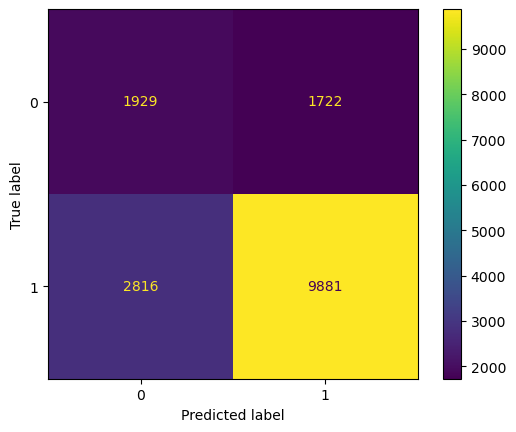

In [50]:
y_pred = label_model.predict(X_test, tie_break_policy="random")

# print("Precision:",metrics.precision_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [33]:
# save the summary to a csv file
summary.to_csv('data/label_model_summary_train by label type.csv', index=False)

All label types in one

In [37]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary().to_csv('data/label_model_LFAnalysis_all on one.csv', index=False)


In [39]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

majority_acc = majority_model.score(L=X_test, Y=y_test, metrics=["accuracy"], tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

majority_pre = majority_model.score(L=X_test, Y=y_test, metrics=["precision"], tie_break_policy="random")["precision"]
print(f"{'Majority Vote precision:':<25} {majority_pre * 100:.1f}%")

majority_rec = majority_model.score(L=X_test, Y=y_test, metrics=["recall"], tie_break_policy="random")["recall"]
print(f"{'Majority Vote recall:':<25} {majority_pre * 100:.1f}%")




Majority Vote Accuracy:   73.7%
Majority Vote precision:  85.3%
Majority Vote recall:     85.3%


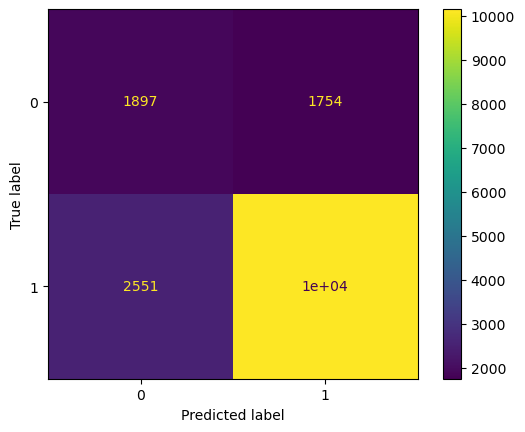

In [42]:
y_pred = majority_model.predict(X_test, tie_break_policy="random")

# print("Precision:",metrics.precision_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [45]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of WRONG")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
probs_train
# plot_probabilities_histogram(probs_train[:, WRONG])

array([[0.5       , 0.5       ],
       [0.63951755, 0.36048245],
       [0.26382673, 0.73617327],
       ...,
       [0.66751606, 0.33248394],
       [0.66751606, 0.33248394],
       [0.66751606, 0.33248394]])

In [52]:
probs_train[:, WRONG]

array([0.5       , 0.63951755, 0.26382673, ..., 0.66751606, 0.66751606,
       0.66751606])

In [8]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [9]:
# probs_train_filtered
df_train_filtered

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,...,way_primary,way_primary_link,way_residential,way_secondary,way_secondary_link,way_tertiary,way_tertiary_link,way_trunk,way_trunk_link,way_unclassified
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.875000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,False,False,False,False,False,False,False,False,False,False
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.500000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,False,False,False,False,False,True,False,False,False,False
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.000000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,False,False,False,False,False,True,False,False,False,False
7,85099,CurbRamp,1.0,uEL6f2Eh9sX_PSPkQnawTg,2,57.839287,-6.669643,57.831257,3.035278,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,False,False,False,True,False,False,False,False,False,False
8,85100,CurbRamp,1.0,uEL6f2Eh9sX_PSPkQnawTg,2,71.053574,-7.473214,57.831257,3.035278,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178958,231270,CurbRamp,1.0,R-sTl5O6sOdVPurgTWy3EQ,1,332.468750,-35.000000,215.130295,-0.157570,155af0a9-4149-4436-8aa3-7573e160036d,...,False,False,True,False,False,False,False,False,False,False
178959,231285,NoSidewalk,5.0,N5MrAAtHZO2JGXUrYAYnSQ,3,0.890625,-11.656250,179.161057,-5.825714,155af0a9-4149-4436-8aa3-7573e160036d,...,False,False,False,False,False,False,False,False,False,False
178960,231338,CurbRamp,1.0,d3oBrJ-nDtKMwlE7svc6pg,1,253.562500,-35.000000,177.959915,-0.962440,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,...,False,False,True,False,False,False,False,False,False,False
178961,231339,CurbRamp,1.0,AOIBJ12BjFanDJF1Ark05Q,1,110.312500,-35.000000,179.365723,-1.093400,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,...,False,False,True,False,False,False,False,False,False,False


In [10]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered) # Target variable

merged = pd.concat([df_train_filtered, pd.DataFrame(preds_train_filtered, index=df_train_filtered.index, columns=['LM_hard label']), pd.DataFrame(probs_train_filtered[:,WRONG], index=df_train_filtered.index, columns=['LM_soft probability of wrong'])], axis=1)
# merged = merged.rename(columns={merged.columns[0]: 'LM_hard output', merged.columns[1]: 'LM_soft probability'})


In [12]:
# merged.head()
merged.to_csv('data/labelModel_outputs_Seattle_encoded_2.csv', index=False)